In [1]:
from collections import defaultdict
from pathlib import Path

import colorcet as cc
import equinox as eqx
import jax
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    root_mean_squared_error as root_mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import NeuralODE
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_default_device", jax.devices("gpu")[2])
jax.config.update("jax_enable_x64", True)


SOLVERS_ALL = (
    "euler",
    "tsit5",
    "adaptive",
)
SOLVERS = (
    "euler",
    "tsit5",
    # "tangent_evolution",
    # "proxy_tangent_evolution",
    "adaptive",
    # "pca",
)

COLOR_DICT = dict(
    zip(
        SOLVERS_ALL,
        (
            "royalblue",
            "limegreen",
            "orangered",
        ),
    )
)
# LABEL_DICT = dict(
#     zip(
#         SOLVERS_ALL,
#         (
#             "Vanilla",
#             "Jacobian matching",
#             "Tangent Evolution matching",
#             "Neighborhood-based (ours)",
#             "Normal-based (ours)",
#             "Identity (ours)",
#         ),
#     )
# )
LABEL_DICT = dict(
    zip(
        SOLVERS_ALL,
        (
            "Euler",
            "Tsit5",
            "Adaptive",  # "Sobolev",
        ),
    )
)

In [2]:
def load_experiment(
    solver_type: str,
    key: int,
    downsample: int,
    train_length: int,
    noise: float,
    rootdir=Path("../../results/smaller_datasets/50_500/lorenz63"),
) -> NeuralODE:
    loaddir = rootdir / f"downsample={downsample}/len={train_length}/" / "vanilla"

    model_path_template = f"*lr=0.002_noise={noise}_key={key}*"
    if solver_type != "adaptive":
        loaddir = loaddir / solver_type

    model_paths = list(loaddir.glob(model_path_template))
    if len(model_paths) == 0:
        raise ValueError("No models found with the given conditions")
    elif len(model_paths) > 1:
        raise ValueError("Multiple models found with the given conditions!")
    else:
        return load_model(model_paths[0])


In [3]:
downsample = 10
noise = 0.1

datadir = Path("../../data")

dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)
dataset_test = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large_test.hdf5")[:100]
    )
    .downsample(downsample)
    .add_noise(0.0)
    .apply_transform(transform)
)


In [4]:
train_length = 2

In [5]:
key = 0
traj_idx = 0
t_traj, u_traj = dataset_test[traj_idx]

n_short = 100
t_short_norm = np.arange(n_short) * 0.01 * downsample
t_short, u_short = t_traj[:n_short], u_traj[:n_short]

u_short_dict = defaultdict(list)
for solver in tqdm(SOLVERS):
    model = load_experiment(
        solver, key, downsample=downsample, train_length=train_length, noise=noise
    )
    u_short_dict[solver] = model.solve(t_short, u_short[0])
    # u_short_dict[solver] = solve_ode(model, t_short, u_short[0], rtol=1e-4, atol=1e-6)

100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Text(0.5, 0.98, 'Short term predictions: train_length=2, seed=0')

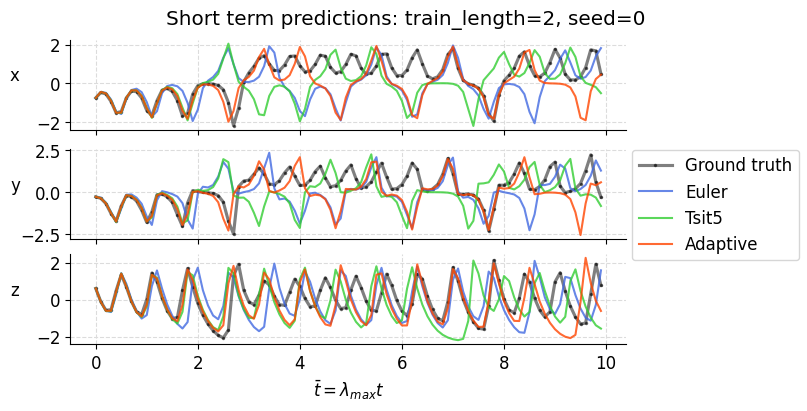

In [6]:
plot_kwargs = {"linewidth": 1.5, "alpha": 0.8}

fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
for i, (ax, y_name) in enumerate(zip(axes.flat, ("x", "y", "z"))):
    ax.plot(
        t_short_norm,
        u_short[:, i],
        ".-",
        color="black",
        linewidth=2.25,
        alpha=0.5,
        label="Ground truth",
    )
    for solver, u_pred in u_short_dict.items():
        ax.plot(
            t_short_norm,
            u_pred[:, i],
            color=COLOR_DICT[solver],
            label=LABEL_DICT[solver],
            **plot_kwargs,
        )
    ax.set_ylabel(y_name, rotation="horizontal")
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
fig.align_ylabels()
fig.legend(
    *ax.get_legend_handles_labels(), loc="outside center right", fontsize="medium"
)
fig.suptitle(f"Short term predictions: {train_length=}, seed={key}", fontsize="large")

In [7]:
key = 0
jacobian_batch = eqx.filter_vmap(jacobian, in_axes=(None, None, 0))
jac_true = jacobian_batch(
    TransformedODE(Lorenz63(), transform), 0.0, dataset_test.u[:, 0]
)


@eqx.filter_jit
def compute_jac_err(model):
    jac_pred = jacobian_batch(model, 0.0, dataset_test.u[:, 0])
    return relative_error_norm(jac_pred, jac_true, axis=(-2, -1))


jac_logerr_dict = defaultdict(list)
for solver in tqdm(SOLVERS):
    jac_logerr_dict[solver] = np.log10(
        compute_jac_err(
            load_experiment(
                solver,
                key,
                downsample=downsample,
                train_length=train_length,
                noise=noise,
            )
        )
    )

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Text(0, 0.5, '$\\log_{10}||\\mathbf{J}_{true}-\\mathbf{J}_{pred}||_F\\;/\\;||\\mathbf{J}_{true}||_F$')

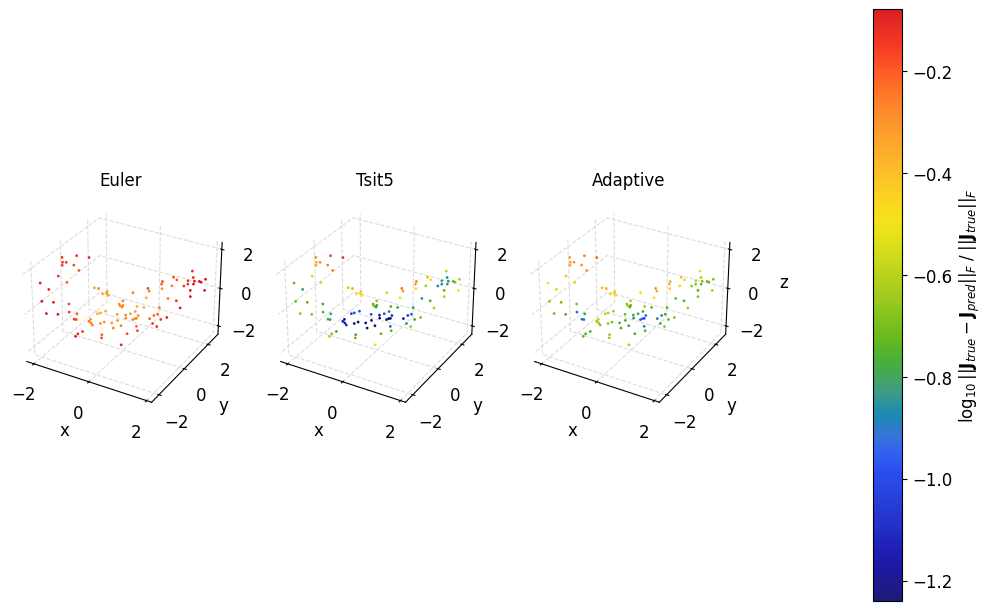

In [8]:
fig = colored_scatterplot(
    [dataset_test.u[:, 0].T] * len(SOLVERS),
    [jac_logerr_dict[solver] for solver in SOLVERS],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)
for i, solver in enumerate(SOLVERS):
    fig.axes[i].set_title(LABEL_DICT[solver], fontsize="medium")
    set_labels(fig.axes[i], ["x", "y", "z"])
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)